# From Chatbots to Agents: Building AI Systems That Actually Get Things Done

## Tech Talk Demo Notebook

This notebook demonstrates the evolution from simple chatbots to intelligent multi-agent systems using LangGraph and LangChain.

### What You'll Learn:
1. **Simple Chatbot**: Basic LLM interaction
2. **Multi-Agent System**: Specialized agents working together
3. **Router Pattern**: Intelligent routing to domain experts
4. **State Management**: How agents maintain context

---

## Part 1: Setting Up the Environment


## 📊 Overview: Multi-Agent System Architecture

### Agent Architecture Diagram

This diagram shows the complete multi-agent system architecture, demonstrating how user queries flow through specialized agents with intelligent routing.

**Run the cell below to display the architecture diagram:**

**Key Components:**
- **Interface Agent (Router)**: Classifies and routes requests
- **Specialized Agents**: Billing, Technical (with web_search tool), and Feedback
- **Conditional Routing**: Intelligent decision-making based on query type
- **Tool Integration**: Technical agent can search the web for solutions

📐 Agent Architecture Diagram:


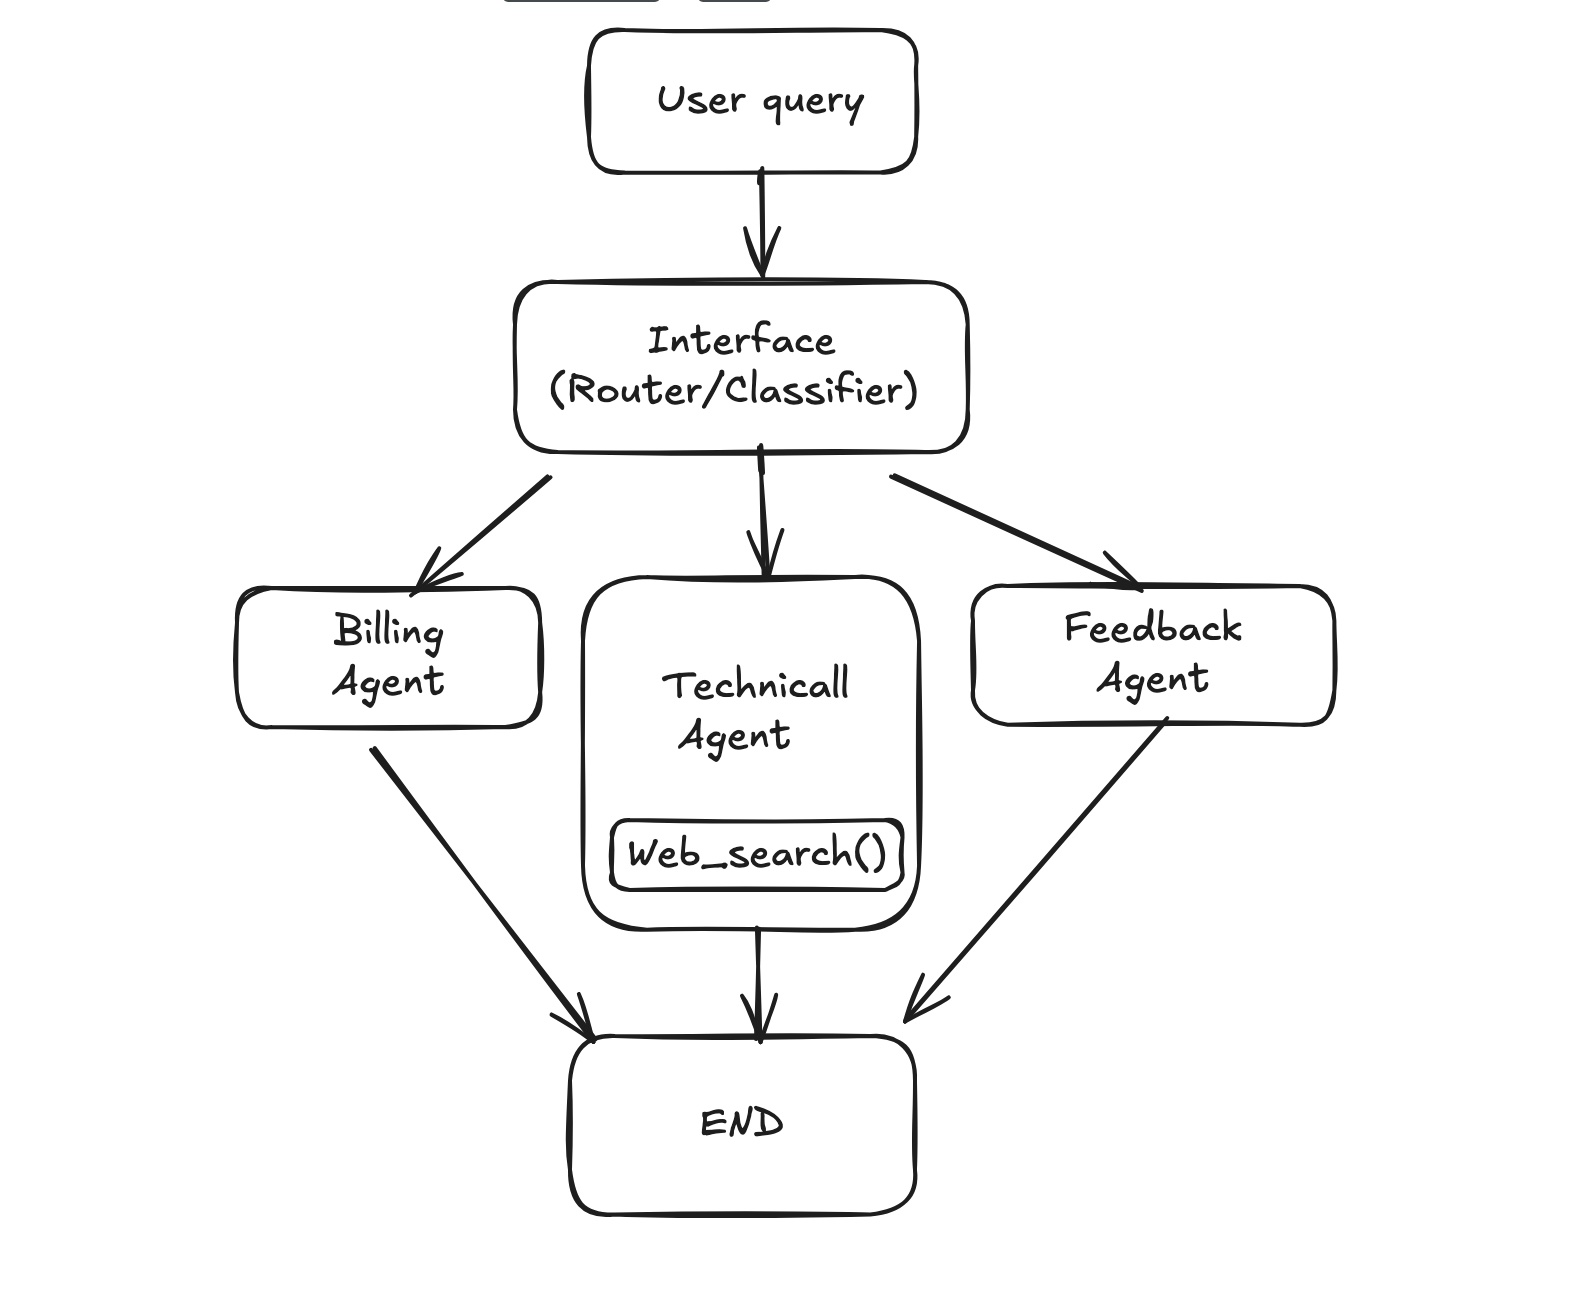


✅ Architecture diagram displayed!


In [ ]:
# Display the architecture diagram
# Path: ../architecture.jpg (from chatbot/ folder to project root)
from IPython.display import Image, display

# Display the architecture diagram
print("📐 Agent Architecture Diagram:")
print("="*60)
display(Image("../architecture.jpg"))
print("\n✅ Architecture diagram displayed!")



In [ ]:

## Part 1: Setting Up the Environment

### Step 1: Install Required Packages

# First, let's install all the necessary dependencies for this project.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

✅ All packages installed successfully!

Installed packages:
  • langgraph - For building multi-agent workflows
  • langchain - Core LLM framework
  • langchain-groq - Groq API integration
  • langchain-tavily - Web search tool for technical agent
  • python-dotenv - Environment variable management
  • ipykernel - Jupyter notebook support


In [ ]:
# Install all required packages
# Run this cell to install dependencies from requirements.txt
# 
# Required packages:
# - langgraph: Graph-based workflow orchestration
# - langchain: LLM framework and prompt templates
# - langchain-groq: Groq LLM integration
# - langchain-tavily: Web search tool integration
# - python-dotenv: Environment variable management
# - ipykernel: Jupyter notebook kernel support

%pip install -r ../requirements.txt

print("\n✅ All packages installed successfully!")
print("\nInstalled packages:")
print("  • langgraph - For building multi-agent workflows")
print("  • langchain - Core LLM framework")
print("  • langchain-groq - Groq API integration")
print("  • langchain-tavily - Web search tool for technical agent")
print("  • python-dotenv - Environment variable management")
print("  • ipykernel - Jupyter notebook support")


### Step 2: Set Up Environment Variables

**Create a `.env` file in the project root directory** (not in the `chatbot/` folder) with your API keys.

The `.env` file should contain:
- `GROQ_API_KEY` - For LLM inference
- `TAVILY_API_KEY` - For web search tool (used by technical agent)

**Where to get API keys:**
- **GROQ_API_KEY**: Get it from https://console.groq.com/
- **TAVILY_API_KEY**: Get it from https://tavily.com/

In [ ]:
### Step 3: Load Environment Variables
# This loads the .env file from the project root
import os
from dotenv import load_dotenv

# Load environment variables from .env file
# This will look for .env in the parent directory (project root)
load_dotenv(dotenv_path="../.env")

# Verify API keys are loaded
groq_key = os.getenv("GROQ_API_KEY")
tavily_key = os.getenv("TAVILY_API_KEY")

if groq_key:
    print("✅ GROQ_API_KEY loaded successfully!")
else:
    print("⚠️  GROQ_API_KEY not found. Please add it to your .env file.")

if tavily_key:
    print("✅ TAVILY_API_KEY loaded successfully!")
else:
    print("⚠️  TAVILY_API_KEY not found. Please add it to your .env file.")
    print("   (Required for technical agent's web_search tool)")

print("\n✅ Environment variables loaded!")


✅ GROQ_API_KEY loaded successfully!
✅ TAVILY_API_KEY loaded successfully!

✅ Environment variables loaded!


In [ ]:
### Step 4: Import Libraries

Import LangChain and LangGraph components:


✅ All libraries imported successfully!

Imported packages:
  • langchain_groq - Groq LLM
  • langchain_core - Core LangChain components
  • langchain_tavily - Web search tool
  • langgraph - Graph workflow orchestration
  • langgraph.prebuilt - Prebuilt tool nodes


In [ ]:
# Import LangChain and LangGraph components
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_tavily import TavilySearch  # For web search tool
from typing import TypedDict
from typing_extensions import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition  # For tool handling

print("✅ All libraries imported successfully!")
print("\nImported packages:")
print("  • langchain_groq - Groq LLM")
print("  • langchain_core - Core LangChain components")
print("  • langchain_tavily - Web search tool")
print("  • langgraph - Graph workflow orchestration")
print("  • langgraph.prebuilt - Prebuilt tool nodes")


In [ ]:
### Step 5: Initialize LLM and Define State

Initialize the LLM and define the State structure for LangGraph:


LLM Response: Hello! I’m here and ready to help. How can I assist you today?

✅ LLM initialized and tested!
✅ State structure defined!


In [ ]:
# Initialize the LLM (Large Language Model)
# We're using Groq's API which provides fast inference
# The model "openai/gpt-oss-20b" is a 20 billion parameter model
llm = ChatGroq(model="openai/gpt-oss-20b", api_key=os.getenv("GROQ_API_KEY"))

# Test the LLM with a simple message
test_response = llm.invoke("Hello! Can you confirm you're working?")
print("LLM Response:", test_response.content)
print("\n✅ LLM initialized and tested!")

# Define the State structure for LangGraph
# This is a TypedDict that defines what data flows through our graph
# The 'messages' field uses Annotated to tell LangGraph how to merge messages
class State(TypedDict):
    messages: Annotated[list, add_messages]  # Automatically handles message history

print("✅ State structure defined!")


In [36]:
# ============================================================================
# AGENT 1: INTERFACE AGENT (The Router/Classifier)
# ============================================================================
# This agent acts as the "front door" - it analyzes incoming requests
# and determines which specialist should handle them.
# 
# Key Concept: This is the "intelligence" that makes routing decisions
# ============================================================================

def interface_llm(state: State):
    """
    Interface Agent: The Router/Classifier
    
    Purpose:
    - Analyzes the incoming customer inquiry
    - Classifies it into one of three categories: Billing, Technical, or Feedback
    - This classification determines which specialist agent will handle the request
    
    Why this matters:
    - Instead of one generic chatbot, we now have a smart router
    - The router understands context and makes routing decisions
    - This is the first step toward an agentic system
    """
    # Create a specialized prompt for classification
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
         "You are a customer care bot, tell me whether the given problem is "
         "based on Billing Issue, Technical Issue, or Feedback."),
        ("user", "issue: {issue}")
    ])
    
    # Create a chain: prompt -> LLM
    # The | (pipe) operator chains components together in LangChain
    # This creates a pipeline: prompt template -> LLM
    # When invoked, it will: format the prompt -> send to LLM -> return response
    chain = prompt | llm
    
    # Get the user's message (the last message in the state)
    user_msg = state["messages"][-1].content
    
    # Invoke the chain to get classification
    response = chain.invoke({"issue": user_msg})
    
    # Return updated state with classification
    return {"messages": state["messages"] + [response]}

print("✅ Interface Agent (Router) defined!")


✅ Interface Agent (Router) defined!


In [37]:
# ============================================================================
# ROUTER DECISION FUNCTION
# ============================================================================
# This function examines the classification from the interface agent
# and returns the name of the next node to execute.
#
# Key Concept: Conditional routing based on LLM output
# This is what makes the system "agentic" - it makes decisions!
# ============================================================================

def router_decision(state: State):
    """
    Router Decision Function: The Traffic Controller
    
    Purpose:
    - Takes the classification from the interface agent
    - Determines which specialist node should handle the request
    - Returns the name of the next node in the graph
    
    How it works:
    1. Gets the last message (the classification from interface agent)
    2. Parses the classification text
    3. Returns the appropriate node name based on keywords
    
    This is where the "routing intelligence" lives!
    """
    # Get the classification from the interface agent (last message)
    classification = state["messages"][-1].content.lower().strip()
    
    # Route based on keywords in the classification
    # This is a simple keyword-based router, but could be more sophisticated
    if "billing" in classification:
        return "billing_node"  # Route to billing specialist
    elif "technical" in classification:
        return "technical_node"  # Route to technical specialist
    elif "feedback" in classification:
        return "feedback_node"  # Route to feedback specialist
    else:
        # Default to feedback if unclear
        return "feedback_node"

print("✅ Router decision function defined!")


✅ Router decision function defined!


In [38]:
# ============================================================================
# AGENT 2: BILLING SPECIALIST
# ============================================================================
# This is a specialized agent that ONLY handles billing-related inquiries.
# It has domain-specific knowledge and prompts optimized for billing issues.
# ============================================================================

def billing_llm(state: State):
    """
    Billing Specialist Agent
    
    Purpose:
    - Handles all billing-related customer inquiries
    - Has specialized knowledge and prompts for billing issues
    - Can provide detailed, domain-specific responses
    
    Key Difference from Simple Chatbot:
    - This agent is SPECIALIZED - it's an expert in one domain
    - It receives context from the router (the original user message)
    - It can be optimized specifically for billing scenarios
    
    Why this matters:
    - Specialization leads to better responses
    - Each agent can be fine-tuned for its domain
    - The system becomes more reliable and accurate
    """
    # Specialized prompt for billing issues
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
         "You are a billing bot, help the user with their billing issues. "
         "Be empathetic, provide clear steps, and offer to escalate if needed."),
        ("user", "issue: {issue}")
    ])
    
    # Create chain using LangChain's pipe operator (|)
    # This chains the prompt template to the LLM
    chain = prompt | llm
    
    # Get the ORIGINAL user message (second-to-last, since last is classification)
    # This is important: we want the original issue, not the classification
    user_msg = state["messages"][-2].content
    
    # Get specialized response
    response = chain.invoke({"issue": user_msg})
    
    # Return updated state
    return {"messages": state["messages"] + [response]}

print("✅ Billing Specialist Agent defined!")


✅ Billing Specialist Agent defined!


In [39]:
# ============================================================================
# AGENT 3: TECHNICAL SPECIALIST (WITH WEB SEARCH TOOL!)
# ============================================================================
# Specialized agent for technical support issues
# This agent has access to web_search tool using Tavily!
# ============================================================================

from langchain_core.tools import tool

# Create web search tool for troubleshooting using Tavily
tavily_tool = TavilySearch(max_results=3)

@tool
def web_search(query: str) -> str:
    """
    Search the web for troubleshooting issues and technical solutions.
    
    Use this tool when you need to find:
    - Recent solutions to technical problems
    - Troubleshooting guides
    - Error message explanations
    - Technical documentation
    
    Args:
        query: The search query for troubleshooting the technical issue
        
    Returns:
        Search results with relevant information
    """
    return tavily_tool.invoke(query)

# Bind tools to the LLM for technical agent
technical_llm_with_tools = llm.bind_tools([web_search])

def technical_llm(state: State):
    """
    Technical Support Specialist Agent - WITH WEB SEARCH TOOL!
    
    Purpose:
    - Handles technical issues, bugs, feature requests, troubleshooting
    - Has specialized knowledge for technical problem-solving
    - Can provide step-by-step technical guidance
    - **NEW**: Can search the web for up-to-date solutions!
    
    Specialization Benefits:
    - Can use technical terminology appropriately
    - Understands common technical issues
    - Can provide structured troubleshooting steps
    - **Can find real-time solutions** using web_search tool
    
    Key Enhancement:
    - This agent can now ACTUALLY GET THINGS DONE by searching the web
    - It can find recent solutions, error explanations, and troubleshooting guides
    - This demonstrates how agents can use tools to extend their capabilities!
    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
         "You are a technical support bot. Help users with their technical issues. "
         "You have access to a web_search tool that you can use to find recent solutions, "
         "troubleshooting guides, and technical documentation. Use the web_search tool when "
         "you need to find up-to-date information about technical problems or error messages."),
        ("user", "issue: {issue}")
    ])
    
    # Use LLM with tools bound (instead of regular llm)
    chain = prompt | technical_llm_with_tools
    user_msg = state["messages"][-2].content  # Original user message
    response = chain.invoke({"issue": user_msg})
    
    return {"messages": state["messages"] + [response]}

print("✅ Technical Specialist Agent defined with web_search tool!")
print("   🔧 This agent can now search the web for troubleshooting solutions!")


✅ Technical Specialist Agent defined with web_search tool!
   🔧 This agent can now search the web for troubleshooting solutions!


In [40]:
# ============================================================================
# AGENT 4: FEEDBACK SPECIALIST
# ============================================================================
# Specialized agent for handling customer feedback (positive or negative)
# ============================================================================

def feedback_llm(state: State):
    """
    Feedback Specialist Agent
    
    Purpose:
    - Handles customer feedback, reviews, suggestions, complaints
    - Acknowledges feedback appropriately
    - Can route to appropriate teams if needed
    
    Specialization Benefits:
    - Empathetic and appreciative tone
    - Understands the value of customer feedback
    - Can categorize feedback for internal use
    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
         "You are a feedback bot, thank the user for their feedback and assure them "
         "that their feedback is valuable. Be warm, appreciative, and show that you care."),
        ("user", "issue: {issue}")
    ])
    
    chain = prompt | llm
    user_msg = state["messages"][-2].content  # Original user message
    response = chain.invoke({"issue": user_msg})
    
    return {"messages": state["messages"] + [response]}

print("✅ Feedback Specialist Agent defined!")


✅ Feedback Specialist Agent defined!


In [41]:
# ============================================================================
# BUILDING THE MULTI-AGENT GRAPH
# ============================================================================
# This is where we CONNECT all the agents we created into a coordinated system.
# 
# Graph Structure:
#   START -> interface_node (router) -> [conditional routing] -> specialist -> END
#
# Key Concepts:
# 1. All requests start at the interface_node (router)
# 2. Router classifies and routes to appropriate specialist
# 3. Each specialist handles the request and ends the workflow
# ============================================================================

# Create a new graph builder
# This is like creating an empty blueprint for our workflow
graph_builder = StateGraph(State)

# ============================================================================
# STEP 1: ADD AGENT NODES TO THE GRAPH
# ============================================================================
# This is where we connect the agents we created earlier!
# Each agent function we defined becomes a "node" in the graph
# 
# Note: In production code (like graph.py), these agent functions would be
# imported from separate files (agents/interface.py, agents/billing.py, etc.)
# ============================================================================

graph_builder.add_node("interface_node", interface_llm)  # Router/Classifier
graph_builder.add_node("billing_node", billing_llm)      # Billing Specialist
graph_builder.add_node("technical_node", technical_llm)  # Technical Specialist (with tools!)
graph_builder.add_node("feedback_node", feedback_llm)    # Feedback Specialist

# Add tool node for technical agent (web_search)
# This node executes the web_search tool when the technical agent calls it
graph_builder.add_node("technical_tool_node", ToolNode([web_search]))

print("✅ All agent nodes added to graph!")
print("   - Agents were CREATED in Part 3 (with their prompts and behavior)")
print("   - Agents are now CONNECTED to the graph here!")
print("   - Technical agent has a tool node for web_search!")

# Define the workflow edges
# ============================================================================
# EDGE 1: START -> interface_node
# ============================================================================
# All requests must first go through the router
# This ensures every request is classified before routing
graph_builder.add_edge(START, "interface_node")

print("✅ Entry point configured: START -> interface_node")

# ============================================================================
# EDGE 2: Conditional Routing from interface_node
# ============================================================================
# This is the KEY difference from a simple chatbot:
# - Instead of a linear flow, we have CONDITIONAL routing
# - The router_decision function determines which path to take
# - This makes the system "intelligent" and "agentic"
# ============================================================================
graph_builder.add_conditional_edges(
    "interface_node",           # From this node...
    router_decision,            # Use this function to decide...
    {                          # Map return values to node names
        "billing_node": "billing_node",
        "technical_node": "technical_node",
        "feedback_node": "feedback_node"
    }
)

print("✅ Conditional routing configured: interface_node -> [specialist]")

# ============================================================================
# EDGES 3-5: Specialist nodes routing
# ============================================================================
# Billing and Feedback nodes end the workflow directly
# Technical node can call tools, so it needs conditional routing
# ============================================================================

# Billing and Feedback nodes end the workflow
graph_builder.add_edge("billing_node", END)
graph_builder.add_edge("feedback_node", END)

# Technical node can call tools, so we need conditional routing
# This checks if the agent wants to call a tool or provide final answer
graph_builder.add_conditional_edges(
    "technical_node",
    tools_condition,  # Check if agent wants to call a tool
    {
        "tools": "technical_tool_node",  # If tool call, go to tool node
        "__end__": END  # If no tool call, end workflow
    }
)

# After tool execution, return to technical agent (creates a loop)
graph_builder.add_edge("technical_tool_node", "technical_node")

print("✅ Exit points configured:")
print("   - billing_node -> END")
print("   - feedback_node -> END")
print("   - technical_node -> [technical_tool_node | END] (conditional)")
print("   - technical_tool_node -> technical_node (loop back)")

# Compile the graph into an executable workflow
multi_agent_graph = graph_builder.compile()

print("\n" + "="*60)
print("🎉 MULTI-AGENT GRAPH COMPILED SUCCESSFULLY!")
print("="*60)
print("\n📊 Graph Structure:")
print("   START → interface_node → [billing_node | technical_node | feedback_node]")
print("   billing_node → END")
print("   feedback_node → END")
print("   technical_node → [technical_tool_node | END] (conditional)")
print("   technical_tool_node → technical_node (loop back)")
print("\n💡 The technical_tool_node will appear in the visualization!")
print("   Re-run Cell 13 to see the updated graph with the tool node.")


✅ All agent nodes added to graph!
   - Agents were CREATED in Part 3 (with their prompts and behavior)
   - Agents are now CONNECTED to the graph here!
   - Technical agent has a tool node for web_search!
✅ Entry point configured: START -> interface_node
✅ Conditional routing configured: interface_node -> [specialist]
✅ Exit points configured:
   - billing_node -> END
   - feedback_node -> END
   - technical_node -> [technical_tool_node | END] (conditional)
   - technical_tool_node -> technical_node (loop back)

🎉 MULTI-AGENT GRAPH COMPILED SUCCESSFULLY!

📊 Graph Structure:
   START → interface_node → [billing_node | technical_node | feedback_node]
   billing_node → END
   feedback_node → END
   technical_node → [technical_tool_node | END] (conditional)
   technical_tool_node → technical_node (loop back)

💡 The technical_tool_node will appear in the visualization!
   Re-run Cell 13 to see the updated graph with the tool node.


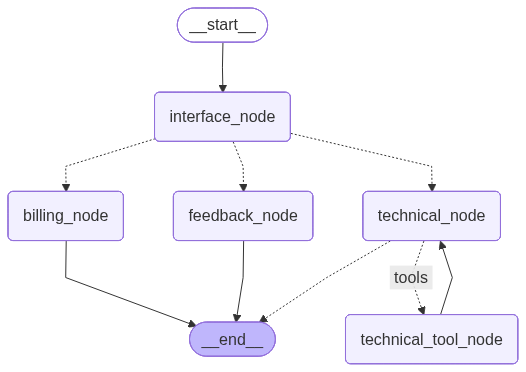

In [42]:
# Visualize the multi-agent graph
# Notice the branching structure - this is what makes it "agentic"!
# The graph shows conditional routing based on the router's decision
from IPython.display import Image, display
display(Image(multi_agent_graph.get_graph().draw_mermaid_png()))


In [43]:
# ============================================================================
# TEST 1: Billing Issue
# ============================================================================
# This should route to the billing specialist
print("="*60)
print("TEST 1: BILLING ISSUE")
print("="*60)

billing_query = "I was charged twice for my subscription this month"
response = multi_agent_graph.invoke({"messages": billing_query})

print(f"\n📝 User Query: {billing_query}")
print(f"\n🔍 Classification: {response['messages'][-2].content}")
print(f"\n💬 Billing Specialist Response:")
print("-" * 60)
print(response["messages"][-1].content)
print("\n✅ Routed to Billing Specialist!")


TEST 1: BILLING ISSUE

📝 User Query: I was charged twice for my subscription this month

🔍 Classification: Billing Issue

💬 Billing Specialist Response:
------------------------------------------------------------
I’m really sorry you’re seeing a duplicate charge—it’s definitely not the experience we want for you. Let’s get this sorted out quickly.

### 1️⃣ Verify the Charge
- **Log in** to your account and go to **Billing → History**.  
- Look for two entries with the same date and amount.  
- If you’re using a mobile app, you can also check your **bank statement** or **payment app** for the same details.

### 2️⃣ Confirm Payment Method
- Make sure the duplicate isn’t coming from a different card or PayPal account that’s linked to the subscription.  
- If you have multiple cards on file, the system might have processed the payment twice by mistake.

### 3️⃣ Request a Refund
- **In‑app / Website**:  
  1. Click the duplicate charge.  
  2. Select “Request Refund” (or “Dispute Charge”).

In [44]:
# ============================================================================
# TEST 2: Technical Issue
# ============================================================================
# This should route to the technical specialist
print("="*60)
print("TEST 2: TECHNICAL ISSUE")
print("="*60)

technical_query = "The app keeps crashing when I try to upload a file"
response = multi_agent_graph.invoke({"messages": technical_query})

print(f"\n📝 User Query: {technical_query}")
print(f"\n🔍 Classification: {response['messages'][-2].content}")
print(f"\n💬 Technical Specialist Response:")
print("-" * 60)
print(response["messages"][-1].content)
print("\n✅ Routed to Technical Specialist!")


TEST 2: TECHNICAL ISSUE

📝 User Query: The app keeps crashing when I try to upload a file

🔍 Classification: {"query": "app keeps crashing when I try to upload a file error troubleshooting", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.facebook.com/groups/Insta360OneCommunity/posts/5838089909614222/", "title": "What causes the PC app to get stuck when uploading files?", "content": "To begin troubleshooting you can rebooting your PC and retesting and making sure you are up to date with Windows updates. You can also go into", "score": 0.61279696, "raw_content": null}, {"url": "https://meta.stackexchange.com/questions/258795/the-android-app-crashes-when-trying-to-upload-a-picture-from-my-phone", "title": "The Android app crashes when trying to upload a picture from my ...", "content": "When trying to upload a picture from my phone, the Android app crashes a few different ways, depending on whether I select the Gallery or Photos image source."

In [45]:
# ============================================================================
# TEST 3: Feedback
# ============================================================================
# This should route to the feedback specialist
print("="*60)
print("TEST 3: FEEDBACK")
print("="*60)

feedback_query = "I love the new feature you added! Great work!"
response = multi_agent_graph.invoke({"messages": feedback_query})

print(f"\n📝 User Query: {feedback_query}")
print(f"\n🔍 Classification: {response['messages'][-2].content}")
print(f"\n💬 Feedback Specialist Response:")
print("-" * 60)
print(response["messages"][-1].content)
print("\n✅ Routed to Feedback Specialist!")


TEST 3: FEEDBACK

📝 User Query: I love the new feature you added! Great work!

🔍 Classification: This is a **Feedback** type message.

💬 Feedback Specialist Response:
------------------------------------------------------------
Thank you so much for sharing that! 🎉 It means a lot to hear that you’re enjoying the new feature. Your feedback is incredibly valuable to us, and it helps keep improving the experience for everyone. If there’s anything else you’d like to see or any suggestions, feel free to let us know—we’re always listening!

✅ Routed to Feedback Specialist!


In [46]:
# ============================================================================
# INSPECTING THE FULL CONVERSATION FLOW
# ============================================================================
# Let's see all the messages in the state to understand the flow
print("="*60)
print("INSPECTING FULL CONVERSATION FLOW")
print("="*60)

test_query = "My payment method was declined"
response = multi_agent_graph.invoke({"messages": test_query})

print(f"\nUser Query: {test_query}\n")
print("Full Message History:")
print("-" * 60)

for i, msg in enumerate(response["messages"]):
    print(f"\n[{i+1}] {type(msg).__name__}:")
    print(f"    {msg.content[:200]}..." if len(msg.content) > 200 else f"    {msg.content}")

print("\n" + "="*60)
print("FLOW ANALYSIS:")
print("="*60)
print("1. User Message: Customer inquiry")
print("2. Interface Agent: Classifies the inquiry")
print("3. Router Decision: Routes to appropriate specialist")
print("4. Specialist Agent: Provides domain-specific response")
print("5. END: Workflow complete")


INSPECTING FULL CONVERSATION FLOW

User Query: My payment method was declined

Full Message History:
------------------------------------------------------------

[1] HumanMessage:
    My payment method was declined

[2] AIMessage:
    **Billing Issue**

[3] AIMessage:
    I’m sorry you’re having trouble—let’s get this sorted out quickly.

**Here’s what you can try right now:**

1. **Check the card details**  
   - Make sure the number, expiration date, CVV, and billing...

FLOW ANALYSIS:
1. User Message: Customer inquiry
2. Interface Agent: Classifies the inquiry
3. Router Decision: Routes to appropriate specialist
4. Specialist Agent: Provides domain-specific response
5. END: Workflow complete


---

## Part 6: Key Takeaways

### What Makes This an "Agentic" System?

1. **Specialization**: Each agent is an expert in its domain
2. **Intelligent Routing**: The system makes decisions about which agent to use
3. **State Management**: Context flows through the graph
4. **Modularity**: Agents can be improved independently
5. **Scalability**: Easy to add new specialist agents

### Comparison: Chatbot vs. Agentic System

| Feature | Simple Chatbot | Multi-Agent System |
|---------|---------------|-------------------|
| **Architecture** | Linear, single node | Graph with conditional routing |
| **Specialization** | One-size-fits-all | Domain-specific experts |
| **Decision Making** | None | Intelligent routing |
| **Scalability** | Limited | Easy to extend |
| **Accuracy** | Generic responses | Specialized, accurate responses |

### Next Steps for Production

1. **Add Memory**: Use checkpoints to remember conversation history
2. **Add Tools**: Give agents access to external APIs and databases
3. **Add Validation**: Validate agent outputs before returning to user
4. **Add Monitoring**: Track routing decisions and agent performance
5. **Add Fallbacks**: Handle edge cases and errors gracefully


---

## Part 7: Advanced: Adding Memory (Optional)

Let's see how we can add conversation memory to make the system even more powerful.


In [47]:
# ============================================================================
# ADDING MEMORY WITH CHECKPOINTS
# ============================================================================
# Memory allows the system to remember previous conversations
# This is crucial for maintaining context across multiple interactions
# ============================================================================

from langgraph.checkpoint.memory import MemorySaver

# Create a memory checkpoint system
# This stores conversation state so agents can remember previous interactions
memory = MemorySaver()

# Recompile the graph with memory
graph_with_memory = graph_builder.compile(checkpointer=memory)

print("✅ Graph compiled with memory support!")

# ============================================================================
# USING MEMORY: Thread-based Conversations
# ============================================================================
# Each conversation thread has a unique ID
# The system remembers context within each thread
# ============================================================================

# Create a conversation thread
thread_config = {"configurable": {"thread_id": "demo-thread-1"}}

# First message in the conversation
print("="*60)
print("CONVERSATION WITH MEMORY")
print("="*60)

response1 = graph_with_memory.invoke(
    {"messages": "My name is Sarah and I have a billing question"},
    config=thread_config
)

print("\n[Message 1]")
print(f"User: My name is Sarah and I have a billing question")
print(f"Agent: {response1['messages'][-1].content[:150]}...")

# Second message - the system should remember the name
response2 = graph_with_memory.invoke(
    {"messages": "What's my name?"},
    config=thread_config
)

print("\n[Message 2]")
print(f"User: What's my name?")
print(f"Agent: {response2['messages'][-1].content[:150]}...")

print("\n✅ Memory is working! The system remembered the user's name.")


✅ Graph compiled with memory support!
CONVERSATION WITH MEMORY

[Message 1]
User: My name is Sarah and I have a billing question
Agent: Hi Sarah! 👋 I’m here to help with any billing questions you have. Could you let me know a bit more about what’s on your mind? For example, are you loo...

[Message 2]
User: What's my name?
Agent: I’m not sure what you’re referring to—could you clarify what you mean by “What’s my name?” If you’re looking for help with a specific technical issue,...

✅ Memory is working! The system remembered the user's name.


---

## Conclusion

### From Chatbots to Agents: The Journey

1. **Started with**: A simple chatbot that treats all queries the same
2. **Evolved to**: A multi-agent system with specialized experts
3. **Key Innovation**: Intelligent routing and decision-making
4. **Result**: A system that actually gets things done!

### Why This Matters

- **Better User Experience**: Users get specialized, accurate responses
- **Maintainability**: Each agent can be improved independently
- **Scalability**: Easy to add new capabilities and agents
- **Reliability**: Specialized agents are more accurate in their domains

### The Future of AI Systems

This pattern - from simple chatbots to intelligent multi-agent systems - represents the future of AI applications. By combining:
- **LLMs** for understanding and generation
- **Graph-based workflows** for orchestration
- **Specialized agents** for domain expertise
- **Intelligent routing** for decision-making

We can build AI systems that are not just conversational, but truly **agentic** - systems that can reason, decide, and act.

---

**Thank you for exploring this demo!**

*For questions or to learn more, check out:*
- LangGraph Documentation: https://langchain-ai.github.io/langgraph/
- LangChain Documentation: https://python.langchain.com/
